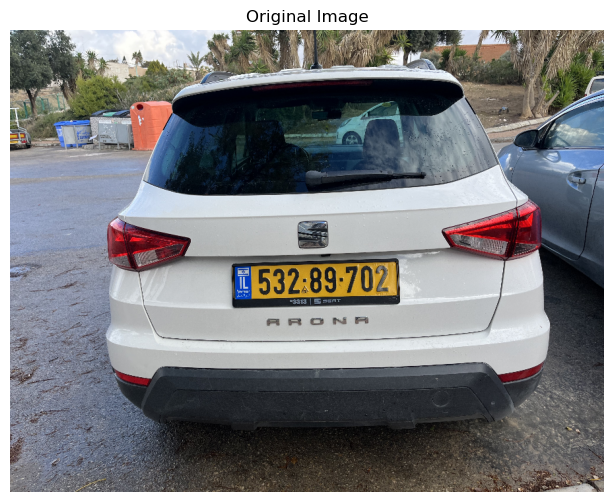

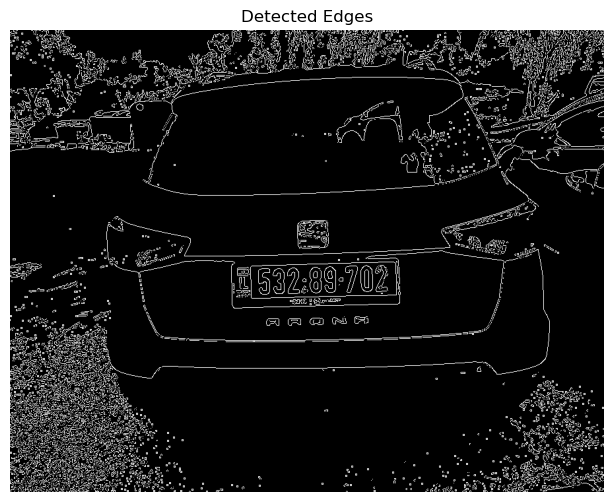

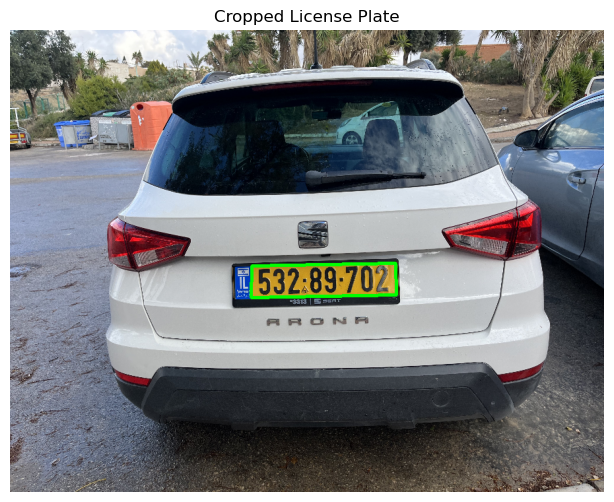

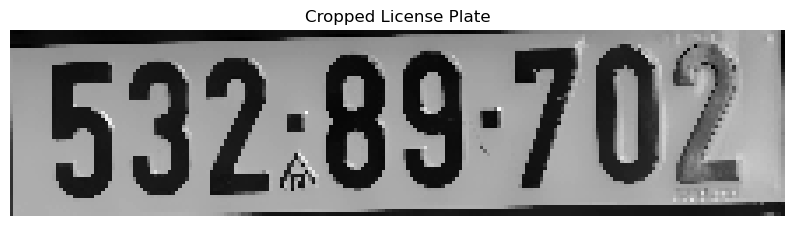

License Plate Text: 532:89:702.


In [10]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Read and display the image
image = cv2.imread('6.jpeg')
image = cv2.resize(image, (900,700))
plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
plt.show()


#Convert image to grayscale and reduce noise
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)


# Detect edges using Canny edge detection
ret, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
edged = cv2.Canny(thresh, 50, 150)
plt.figure(figsize=(10,6))
plt.imshow(edged, cmap='gray')
plt.title("Detected Edges")
plt.axis("off")
plt.show()

# Find contours and filter for a potential license plate
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None

for cnt in cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Check the aspect ratio: width / height
    aspect_ratio = float(w) / float(h)
    if aspect_ratio < 2 or aspect_ratio > 6:
        # Skip if it doesn't fit typical license plate ratio
        continue
    
    peri = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.018 * peri, True)
    if len(approx) == 4:
        screenCnt = approx
        break

if screenCnt is None:
    print("No contour detected that resembles a license plate")
else:
    # Draw the contour on the original image and crop the license plate region
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3)
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Cropped License Plate")
    plt.axis("off")
    plt.show()

    # Create a mask that only includes the detected license plate region
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [screenCnt], 0, 255, -1)
    new_image = cv2.bitwise_and(image, image, mask=mask)

    # Find the coordinates of the mask and crop the license plate area from the grayscale image
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    cropped = gray[topx:bottomx+1, topy:bottomy+1]

    plt.figure(figsize=(10,6))
    plt.imshow(cropped, cmap='gray')
    plt.title("Cropped License Plate")
    plt.axis("off")
    plt.show()

    # OCR to extract text from the license plate
    text = pytesseract.image_to_string(cropped, config='--psm 8')
    print("License Plate Text:", text.strip())
